In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

## Loop downsample size - data generator randomization, NAICS+hierarchy
Randomize training during fit (shuffled), loop downsampling training data.  Loop the downsample fraction.  (Fixed random injection at 10%

NAICS+hierarchy groups, and data with no missing values

*This script takes about 2 hours on my MacBook Air*

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
from pathlib import Path
import importlib, pickle
from sklearn import model_selection
from sklearn.model_selection import train_test_split

In [4]:
import pandas as pd
import os
import re

import keras
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import matplotlib.ticker as ticker

In [6]:
from keras.callbacks import EarlyStopping

In [7]:
from sba_nn.sba_nn import sbnn_metrics, sbnn_model, sbnn_plot
from sba_nn.sba_nn.sbnn_model import CatInjectGenerator

In [8]:
sbnn_plot.plot_defaults()

## Input Data

In [9]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed_nomiss.parquet'))

In [10]:
with open(Path(setup.temp_path).joinpath('01_DATA_features.pkl'), 'rb') as fin:
    imputer_features = pickle.load(fin)

In [11]:
with open(Path(setup.temp_path).joinpath('01_DATA_naics_max_encodings.pkl'), 'rb') as fin:
    naics_max_levels= pickle.load(fin)

##### Features

In [12]:
# Numeric features
features_numeric = [f for f in imputer_features if 'NAICS' not in f]
features_numeric_len = len(features_numeric)
print(features_numeric)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'missingindicator_LowDoc', 'missingindicator_new_business', 'missingindicator_urban_flag']


In [13]:
###### NAICS feature
features_naics = ['NAICS', 'NAICS_4', 'NAICS_3', 'NAICS_sector']
features_naics_max_levels  = [naics_max_levels[n] for n in features_naics]
features_naics_emb_dim = [setup.nn_naics_embed_size_dict[n] for n in features_naics]

In [14]:
print(features_naics_max_levels)
print(features_naics_emb_dim)

[1170, 345, 107, 21]
[8, 4, 4, 2]


##### Datasets for train, validation

In [15]:
X = sba_loans[['dset', 'LoanNr_ChkDgt'] + features_numeric + features_naics].set_index('LoanNr_ChkDgt').sort_index()

In [16]:
X_train = X[X['dset'] == 'train'].drop(columns='dset')
y_train = sba_loans[sba_loans['dset'] == 'train'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'training X: {X_train.shape}, y:{y_train.shape}')

training X: (446848, 14), y:(446848,)


In [17]:
X_val = X[X['dset'] == 'val'].drop(columns='dset')
y_val = sba_loans[sba_loans['dset'] == 'val'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'val X: {X_val.shape}, y:{y_val.shape}')

val X: (95604, 14), y:(95604,)


In [18]:
base_thresh = y_train.mean()
print(base_thresh)

0.20230592953308507


## Create, fit model

## Loop for different fits

In [19]:
def gen_fit_loop(rate=0.1, injection_rate = 0.1):
    this_model = sbnn_model.create_emb_model(features_numeric_len,
                                         features_naics_max_levels,
                                         features_naics_emb_dim,
                                         naics_embedding_names = features_naics,
                                         hidden_size = setup.nn_layer_sizes,
                                         activation='tanh',
                                         lr=setup.nn_learning_rate,
                                         opt_func = setup.nn_optimizer,
                                         dropout = setup.nn_dropout)
    
    # Downsample
    train_samp, _ = train_test_split(X_train.index,
                                train_size=rate,
                                random_state=343)
    X_train_ds = X_train.loc[train_samp, :]
    y_train_ds = y_train.loc[train_samp]
    
    
    generator = CatInjectGenerator(X_train_ds, y_train_ds,
                               categorical_columns=features_naics,
                               batch_size = setup.nn_batch_size,
                               injection_rate = injection_rate,
                               injection_value = 1)
    callback = keras.callbacks.EarlyStopping(patience=3)
    
    this_history = this_model.fit(generator,
                              batch_size=setup.nn_batch_size,
                              epochs = setup.nn_epochs,
                              validation_data=([X_val[features_numeric]] + [X_val[f] for f in features_naics], 
                                               y_val),
                              shuffle=True,
                             callbacks=[callback])
    this_history_df = sbnn_model.process_history(this_history)
    this_history_df['rate'] = rate
    
    # Predictions then metrics
    this_predict = this_model.predict([X[features_numeric]]+ [X[f] for f in features_naics])
    this_predict_df = pd.DataFrame(this_predict, index=X.index) \
        .set_axis(['predict_prob'], axis=1) \
        .reset_index() \
        .merge(sba_loans[['target', 'LoanNr_ChkDgt', 'dset', 'dset_naics_holdout', 'NAICS']], 
               on='LoanNr_ChkDgt')
    
    # Threshold tune
    this_pred_train = this_predict_df[this_predict_df['dset'] == 'train']
    thresh_tune_data = sbnn_metrics.get_f1_frame(this_pred_train['target'], 
                                        this_pred_train['predict_prob'])
    thresh_tune_data.sort_values('f1', ascending=False, inplace=True)
    best_thresh = thresh_tune_data['thresh'].iloc[0]
    this_predict_df['predict_bin'] = sbnn_metrics.get_binary_predictions(this_predict_df['predict_prob'], 
                                                                            best_thresh)
    
    this_metrics_dset = this_predict_df.groupby('dset') \
        .apply(lambda x: sbnn_metrics.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    this_metrics_test = this_predict_df[this_predict_df['dset'] == 'test'] \
        .groupby(['dset', 'dset_naics_holdout']) \
        .apply(lambda x: sbnn_metrics.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    this_metrics = pd.concat([this_metrics_dset, this_metrics_test])
    this_metrics['rate'] = rate
    this_metrics['thresh'] = best_thresh
    
    return this_history_df, this_metrics


## Run Loop

In [20]:
sample_rate_vals = [0.01, 0.05, 0.1, 0.2, 0.4, 0.7, 0.9, 0.95, 1]

In [21]:
history = pd.DataFrame()
metrics = pd.DataFrame()

In [22]:
%%capture
for r in sample_rate_vals:
    this_hist, this_met = gen_fit_loop(r)
    history = pd.concat([history, this_hist])
    metrics = pd.concat([metrics, this_met])

2024-05-25 07:04:10.220954: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-25 07:04:10.220982: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-25 07:04:10.220996: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-25 07:04:10.221046: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-25 07:04:10.221064: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-05-25 07:04:12.016142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-25 07:04:21.094499: I t

In [23]:
history['epoch'] = history.groupby('rate').cumcount()
history.to_csv(Path(setup.temp_path).joinpath('35_REPORT_loop_history.csv'))

In [24]:
metrics.to_csv(Path(setup.temp_path).joinpath('35_REPORT_loop_metrics.csv'))

In [25]:
metrics[metrics['dset_naics_holdout'] == 0]

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout,rate,thresh
0,test,0.562858,0.407271,0.281067,0.739171,0.315451,0.674197,0.0,0.01,0.14
0,test,0.614586,0.424196,0.304539,0.698738,0.333406,0.693169,0.0,0.05,0.20
0,test,0.629645,0.433524,0.314499,0.697502,0.349323,0.705285,0.0,0.10,0.18
0,test,0.651192,0.440595,0.326778,0.676075,0.367385,0.716718,0.0,0.20,0.20
0,test,0.637923,0.444487,0.322898,0.712954,0.373761,0.721481,0.0,0.40,0.20
0,test,0.650889,0.445497,0.328883,0.690240,0.376823,0.724554,0.0,0.70,0.24
0,test,0.666032,0.447882,0.337206,0.666701,0.377124,0.726386,0.0,0.90,0.26
0,test,0.656687,0.447245,0.332340,0.683595,0.379364,0.725900,0.0,0.95,0.22
0,test,0.216457,0.338151,0.204104,0.985166,0.177889,0.460231,0.0,1.00,0.26


In [26]:
metrics[metrics['dset_naics_holdout'] == 1]

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout,rate,thresh
1,test,0.515942,0.414779,0.273216,0.860784,0.320583,0.699891,1.0,0.01,0.14
1,test,0.636987,0.441829,0.318513,0.720957,0.344029,0.717422,1.0,0.05,0.20
1,test,0.643249,0.445046,0.322497,0.717814,0.357493,0.725756,1.0,0.10,0.18
1,test,0.675236,0.449898,0.339575,0.666405,0.374543,0.733913,1.0,0.20,0.20
1,test,0.645597,0.449964,0.325725,0.727416,0.378745,0.736038,1.0,0.40,0.20
1,test,0.661373,0.451513,0.333361,0.699398,0.381527,0.737158,1.0,0.70,0.24
1,test,0.660886,0.453526,0.334035,0.706119,0.382834,0.738800,1.0,0.90,0.26
1,test,0.676454,0.453924,0.341989,0.674784,0.380897,0.737402,1.0,0.95,0.22
1,test,0.211337,0.331973,0.199695,0.983329,0.164034,0.433058,1.0,1.00,0.26


## Plots

In [27]:
#metrics = pd.read_csv(Path(setup.temp_path).joinpath('35_REPORT_loop_metrics.csv'))
#history = pd.read_csv(Path(setup.temp_path).joinpath('35_REPORT_loop_history.csv'))

In [28]:
importlib.reload(sbnn_plot)

<module 'sba_nn.sba_nn.sbnn_plot' from '/Users/valeriecarey/Documents/projects/2024_05_blog_nn_rand/code/sba_nn/sba_nn/sbnn_plot.py'>

##### Metrics

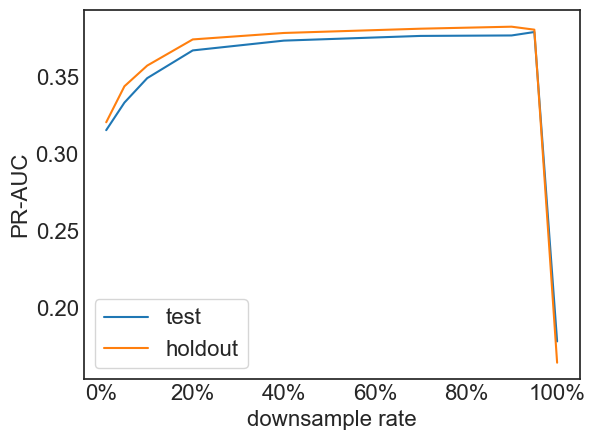

In [29]:
fig = sbnn_plot.plot_metric_dependence(metrics, xformatter = ticker.PercentFormatter(1),
                                      ylabel='PR-AUC',
                            xlabel='downsample rate')
fig.savefig(Path(setup.temp_path).joinpath('35_PLOT_average_precision.png'),
            bbox_inches='tight')

##### History

In [30]:
importlib.reload(sbnn_plot)

<module 'sba_nn.sba_nn.sbnn_plot' from '/Users/valeriecarey/Documents/projects/2024_05_blog_nn_rand/code/sba_nn/sba_nn/sbnn_plot.py'>

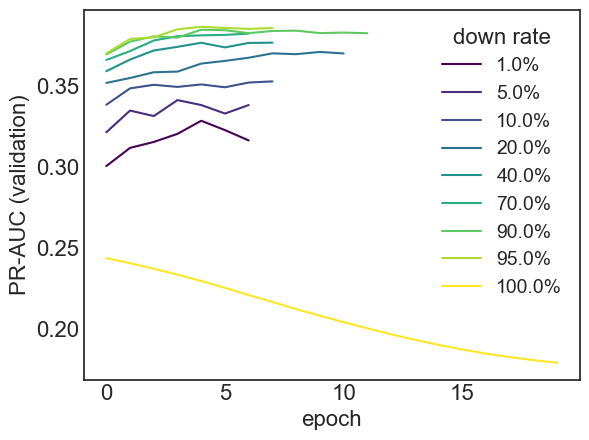

In [31]:
fig = sbnn_plot.plot_history_group(history,
                                  col_format_func = lambda x:f'{float(x):.1%}',
                                  ylabel = 'PR-AUC (validation)',
                                  leg_title='down rate')
fig.savefig(Path(setup.temp_path).joinpath('35_PLOT_hostory_val_auc.png'),
            bbox_inches='tight')

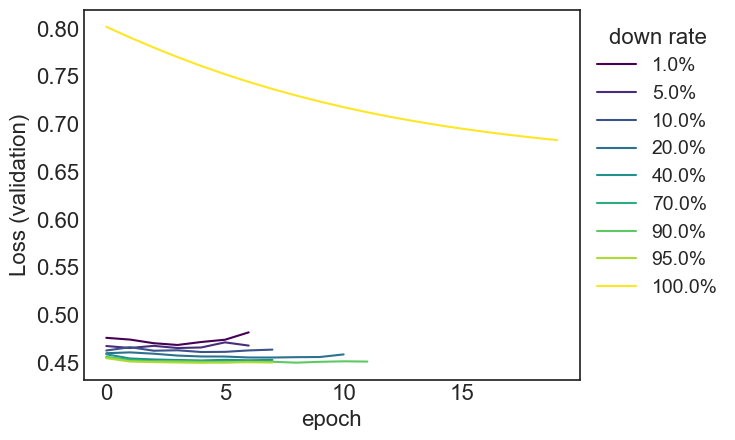

In [32]:
fig = sbnn_plot.plot_history_group(history,'val_loss',
                                  col_format_func = lambda x:f'{float(x):.1%}',
                                  ylabel = 'Loss (validation)',
                                  leg_title='down rate')
fig.savefig(Path(setup.temp_path).joinpath('35_PLOT_hostory_val_loss.png'),
            bbox_inches='tight')

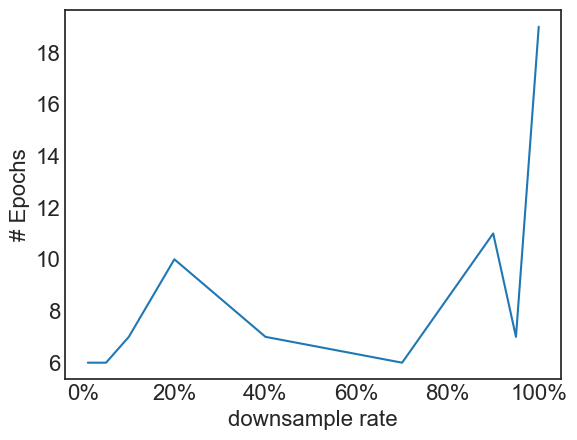

In [33]:
fig = sbnn_plot.plot_epoch_agg(history,
                               xformatter = ticker.PercentFormatter(1),
                               ylabel='# Epochs',
                               xlabel='downsample rate')
fig.savefig(Path(setup.temp_path).joinpath('35_PLOT_hostory_epochs.png'),
            bbox_inches='tight')